## Домашняя работа к уроку №2. Масштабирование признаков. L1- и L2-регуляризация. Стохастический градиентный спуск

### 1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов. ###

Подключим библиотеки 

In [403]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

Реализуем заготовленные функции 

In [404]:
def calc_mse(y, y_pred):
    return (sum((y - y_pred)**2)) / len(y)

Сгенерируем dataset и построим график

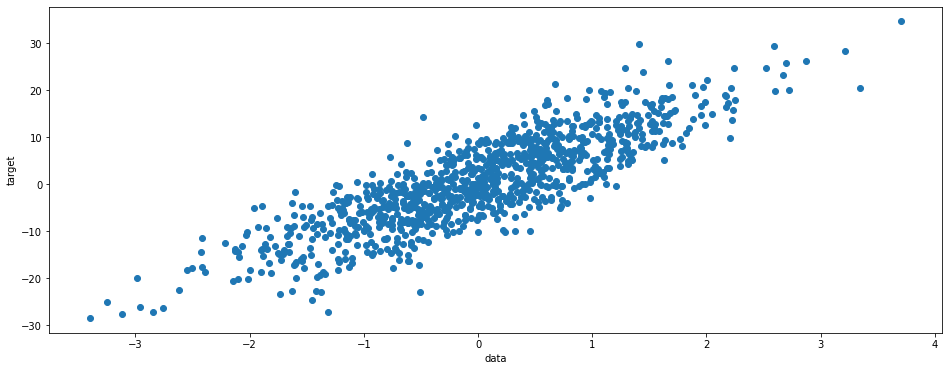

In [405]:
data, target, coef = datasets.make_regression(n_samples=1000,
                                             n_features=1,
                                             n_informative=1,
                                             n_targets=1,
                                             noise=5,
                                             coef=True,
                                             random_state=17)

plt.figure(figsize=(16,6))
plt.scatter(data, target)
plt.xlabel('data')
plt.ylabel('target')
plt.show()

Отмаштабируем данные методом стандартизации

In [406]:
def standardization(X):
    

    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    for i in range(X.shape[1]):
        X[i:] = (X[i:] - means[i]) / stds[i]
    return X

data = standardization(data)

Реализуем модель градиентного спуска используя формулы:

$$w^{k} = w^{k-1} - \eta_{k}\nabla Q(w^{k-1}, X).$$

В качестве скорости обучения возьмем динамически изменяющуюся скорость, так что в случае если ошибка на придедущем шаге стала меньше, чем ошибка на текущем шаге, то:

$$\eta_{\text{new}}=\frac{\eta_{\text{old}}}{\text{speed_divider}}$$. 

При этом выражение градиента в матричной форме выглядит так:

$$\nabla_{w}Q(w,X) = \frac{2}{l}X^{T}(Xw-y).$$

В качестве критерия сходимости запишем следующее условие:

$$||w^{k}-w^{k-1}|| < \varepsilon.$$

In [407]:
def gradient_descent(X:np.array, 
                    y:np.array, 
                    precision=1e-4,
                    speed_divider=10,
                    start_speed_lr=0.05,
                    visualization=False):
    
    X = np.column_stack((np.ones(X.shape[0]), X))
    n, errors, steps_number = X.shape[0], list(), 0 
    w_new = np.random.normal(scale=0.3, size=X.shape[1])
    
    eta = start_speed_lr
    while True: 
        steps_number += 1
        w = w_new
        y_pred = np.dot(X, w)
        errors.append(calc_mse(y, y_pred))
        w_new = w - (eta * (2 / n  * np.dot(X.T, (y_pred - y))))
        if np.linalg.norm(w - w_new, ord=2) < precision:
            break
        new_error = calc_mse(y, np.dot(X, w_new)) 
        eta = eta if new_error < errors[-1] else eta / speed_divider
    
    if visualization:
        x = np.linspace(0, steps_number, steps_number, dtype=int)
        plt.scatter(x, errors, c='red', alpha=0.5)
        plt.plot(x, errors, c='blue')
        plt.xlabel('steps number')
        plt.ylabel('MSE')
        plt.title(f'Min error is {round(errors[-1], 3)}, max step is {steps_number}')
        plt.show()
    return w_new, np.dot(X, w_new), errors, steps_number


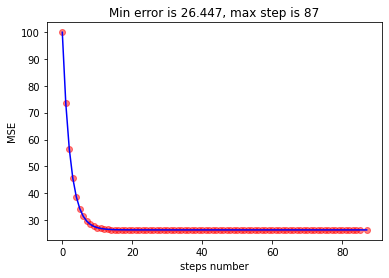

In [408]:
w, y, errors, steps_number = gradient_descent(data, target,start_speed_lr=0.1,visualization=True, precision=1e-9)

Подберем гиперпараметр для данной модели, а именно start_speed_lr. Он регулирует скорость обучения

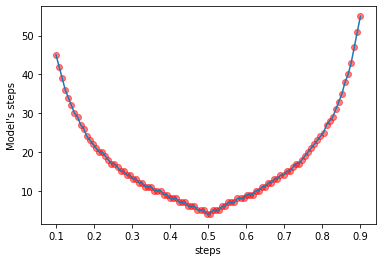

In [409]:
def get_optimal_stemps(X, y, model, steps_param, start_step=0.001, end_step=0.065):
    steps = np.linspace(start_step, end_step, 100)
    count_model_steps = list()
    
    for i in range(steps.shape[0]):
        w, y, err, model_steps = model.__call__(*(X, y), **{steps_param: steps[i]})
        count_model_steps.append(model_steps)

    plt.plot(steps, count_model_steps)
    plt.scatter(steps, count_model_steps, c='red', alpha=0.5)
    plt.xlabel('steps')
    plt.ylabel("Model's steps")
    plt.show()
    
get_optimal_stemps(data, 
                   target, 
                   model=gradient_descent, 
                   steps_param='start_speed_lr', 
                   start_step=0.1, 
                   end_step=0.9)

Видно, что оптимальной начальной скоростью является 0,5. Построим еще раз модель с выбраной начальной скоростью обучения

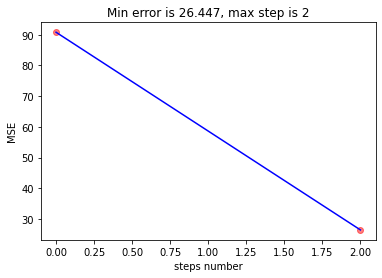

In [410]:
w_gd, y_gd, errors_gd, steps_number_gd = gradient_descent(data, target,start_speed_lr=0.5,visualization=True, precision=1e-9)

Визуализируем полученую модель

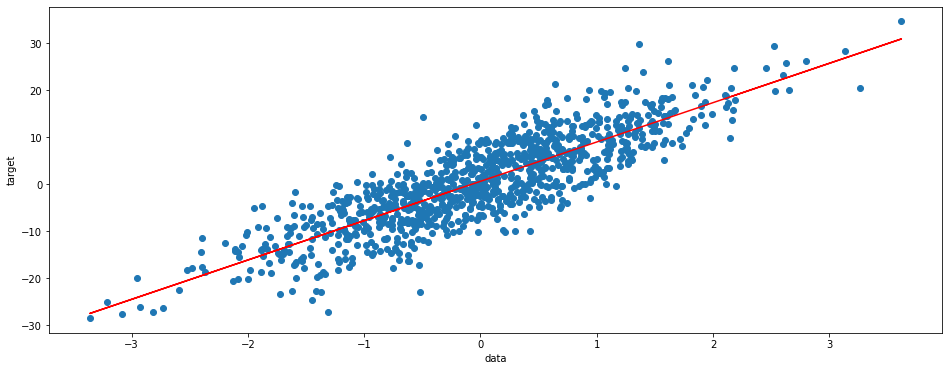

In [411]:
plt.figure(figsize=(16,6))
plt.plot(data, y_gd, c='red')
plt.scatter(data, target)
plt.xlabel('data')
plt.ylabel('target')
plt.show()

Реализуем функцию стахостического градиентного спуска. Для этого модернизируем существующий код для градиентного спуска используя следующие формулы:

$$w^{k} = w^{k-1} - \eta_{k}\nabla Q(w^{k-1}, \{x_{i}\}),$$

где $\nabla Q(w^{k-1}, \{x_{i}\})$ вычисляется для случайно выбраного объекта из dataset. 

Также вместо динамически изменяющейся скорости будем использовать постоянную


In [412]:
test = data.copy()
test = np.column_stack((np.ones(data.shape[0]), test))
w = np.random.normal(scale=0.3, size=test.shape[1])
test[1]

array([ 1.        , -0.27329292])

In [413]:
def SGD(X:np.array, 
        y:np.array, 
        precision=1e-8,
        max_steps_count=10000,
        speed_divider=10,
        eta=0.05,
        visualization=False):
    
    X = np.column_stack((np.ones(X.shape[0]), X))
    n, errors, steps_number = X.shape[0], list(), 0 
    w_new = np.random.normal(scale=0.3, size=X.shape[1])
    

    while True:
        random_index = np.random.randint(data.shape[0])
        steps_number += 1
        w = w_new

        w_new = w - eta * 2 / n  * np.dot(X[random_index].T, (np.dot(X[random_index], w) - y[random_index]))
        
        if np.linalg.norm(w - w_new, ord=2) < precision or steps_number > max_steps_count:
            errors.append(calc_mse(y, np.dot(X, w_new)))
            break
            
        errors.append(calc_mse(y, np.dot(X, w_new)))
#         if len(errors) > 2:
#             eta = eta if errors[-1] < errors[-2] else eta / speed_divider
        
    
    if visualization:
        x = np.linspace(0, steps_number, steps_number, dtype=int)
        
        plt.scatter(x, errors, c='red', alpha=0.5)
        plt.plot(x, errors, c='blue')
        plt.xlabel('steps number')
        plt.ylabel('MSE')
        plt.title(f'Min error is {round(errors[-1], 3)}, max step is {steps_number}')
        plt.show()
    return w_new, np.dot(X, w_new), errors, steps_number

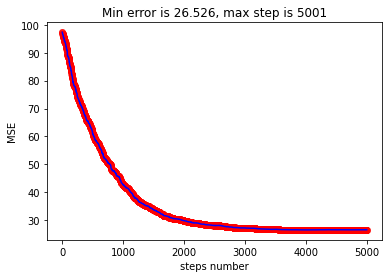

In [414]:
# w, y, errors, steps_number = SGD(data, target,start_speed_lr=0.05,visualization=True, precision=1e-4)
w_sgd, y_sgd, errors_sgd, steps_number_sgd = SGD(data, target, eta=0.4, visualization=True, max_steps_count=5000, precision=1e-9)

Использовать метод для подбора гиперпараметра start_speed_lr который мы использовали для подбора для градиентного спуска в данном случае не годится. Т.к. картина оптимальной скорости будет постоянной меняться от пересчета к пересчету из-за присутствия элемента случайности

Построим решение на основании метода SGD

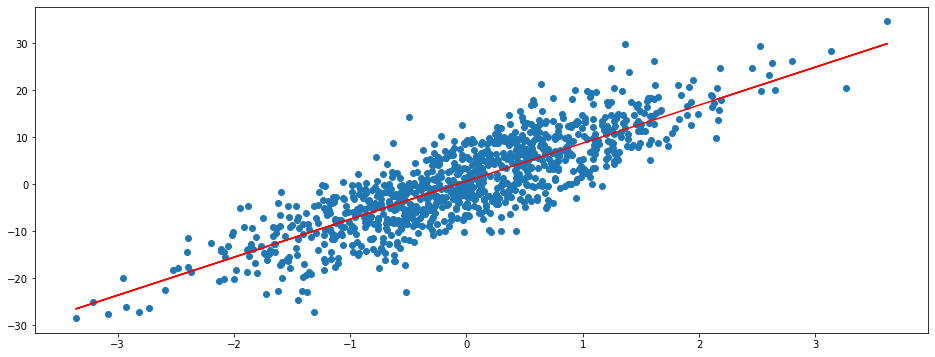

In [415]:
plt.figure(figsize=(16,6))
plt.scatter(data, target)
plt.plot(data, y_sgd, c='red')
plt.show()

Нанесем среднеквадратичную ошибку для обоих методов на один график

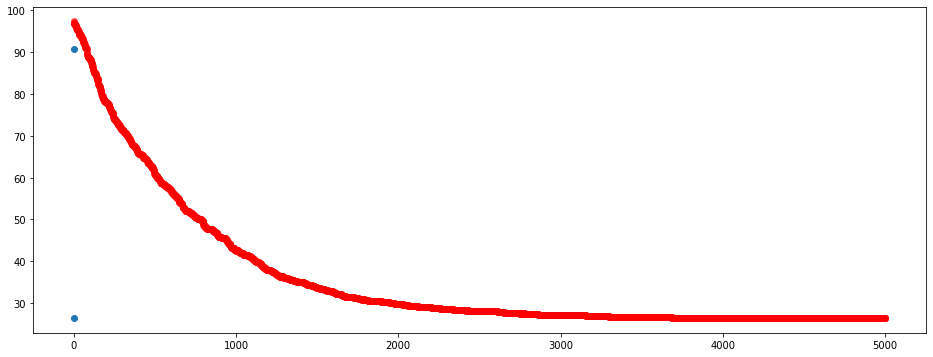

In [416]:
plt.figure(figsize=(16,6))
plt.scatter(np.linspace(start=0, stop=len(errors_gd), num=len(errors_gd)), errors_gd)
plt.scatter(np.linspace(start=0, stop=len(errors_sgd), num=len(errors_sgd)), errors_sgd, c='red', alpha=0.5)
plt.show()

Из графика видно, что реализация градиентного спуска с использованием адаптивной скорости спуска сходится намного быстрее, чем стахостический градиентный спуск

### 2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации и сравнить результаты. ###

Добавим L2 регуляризацию в GD и SGD следующего вида:

$$Q(w, X) + \lambda ||w||^{2} \rightarrow \underset{w}{\text{min}}.$$

Для это нужно переписать критерий сходимости в следующем виде:

$$|Q_k(w, X) - Q_{k-1}(w, X)| < \epsilon$$,

а в функцию, считающую MSE, нужно добавить норму вектора весов

In [417]:
def calc_mse_ridge(y, w, X, lambda_):
    return sum((y - np.dot(X, w)) ** 2) / len(y) + lambda_ * np.linalg.norm(w, ord=2)

def SGD_regular(X:np.array,  
              y:np.array,  
              precision=1e-8, 
              max_steps_count=10000, 
              speed_divider=10, 
              lambda_ = 0.1, 
              eta=0.05, 
              visualization=False,
              regularization_method=calc_mse_ridge):
    
    X = np.column_stack((np.ones(X.shape[0]), X))
    n, errors, steps_number = X.shape[0], list(), 0 
    w_new = np.random.normal(scale=0.3, size=X.shape[1])
    

    while True:
        random_index = np.random.randint(data.shape[0])
        steps_number += 1
        w = w_new

        w_new = w - eta * 2 / n  * np.dot(X[random_index].T, (np.dot(X[random_index], w) - y[random_index]))
        
        errors.append(regularization_method(y, w_new, X, lambda_))
        
        if steps_number > 2:
            if np.abs(errors[-2] - errors[-1]) < precision or steps_number > max_steps_count:
                break
  
    if visualization:
        x = np.linspace(0, steps_number, steps_number, dtype=int)
        
        plt.scatter(x, errors, c='red', alpha=0.5)
        plt.plot(x, errors, c='blue')
        plt.xlabel('steps number')
        plt.ylabel('MSE')
        plt.title(f'Min error is {round(errors[-1], 3)}, max step is {steps_number}')
        plt.show()
    return w_new, np.dot(X, w_new), errors, steps_number



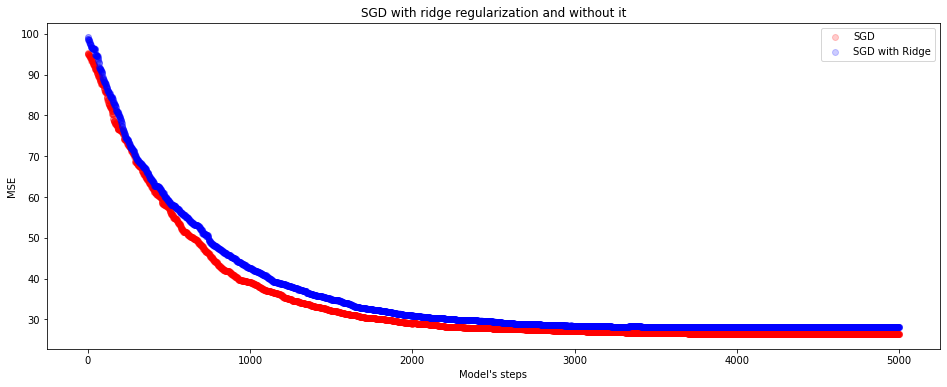

In [418]:
w_sgd_ridge, y_sgd_ridge, errors_sgd_ridge, steps_number_sgd_ridge = SGD_regular(data, target, eta=0.4, max_steps_count=5000, precision=1e-9, lambda_=0.2)
w_sgd, y_sgd, errors_sgd, steps_number_sgd = SGD(data, target, eta=0.4, max_steps_count=5000, precision=1e-9)

plt.figure(figsize=(16, 6))
plt.scatter(np.linspace(start=0, stop=len(errors_sgd), num=len(errors_sgd)), errors_sgd, c='red', alpha=0.2, label='SGD')
plt.scatter(np.linspace(start=0, stop=len(errors_sgd_ridge), num=len(errors_sgd_ridge)), errors_sgd_ridge, c='blue', alpha=0.2, label='SGD with Ridge')
plt.xlabel("Model's steps")
plt.ylabel('MSE')
plt.title('SGD with ridge regularization and without it')
plt.legend()
plt.show()

Из графика выше видно, что модель с регуляризацией увеличивает ошибку. Выполним аналогичные действия для GD

In [419]:
def gradient_descent_regular(X:np.array, 
                           y:np.array, 
                           precision=1e-4,
                           speed_divider=10,
                           start_speed_lr=0.05,
                           visualization=False,
                           lambda_=0.1,
                           regularization_method=calc_mse_ridge):
    
    X = np.column_stack((np.ones(X.shape[0]), X))
    n, errors, steps_number = X.shape[0], list(), 0 
    w_new = np.random.normal(scale=0.3, size=X.shape[1])
    
    eta = start_speed_lr
    while True: 
        steps_number += 1
        w = w_new
        y_pred = np.dot(X, w)
        errors.append(regularization_method(y, w, X, lambda_))
        
        w_new = w - (eta * (2 / n  * np.dot(X.T, (y_pred - y))))
        
        new_error = regularization_method(y, w_new, X, lambda_) 
        eta = eta if new_error < errors[-1] else eta / speed_divider
        
        if steps_number > 2:
            if np.abs(new_error - errors[-1]) < precision:
#                 errors.append(new_error)
                break 
        
    if visualization:
        x = np.linspace(0, steps_number, steps_number, dtype=int)
        plt.scatter(x, errors, c='red', alpha=0.5)
        plt.plot(x, errors, c='blue')
        plt.xlabel('steps number')
        plt.ylabel('MSE')
        plt.title(f'Min error is {round(errors[-1], 3)}, max step is {steps_number}')
        plt.show()
    return w_new, np.dot(X, w_new), errors, steps_number

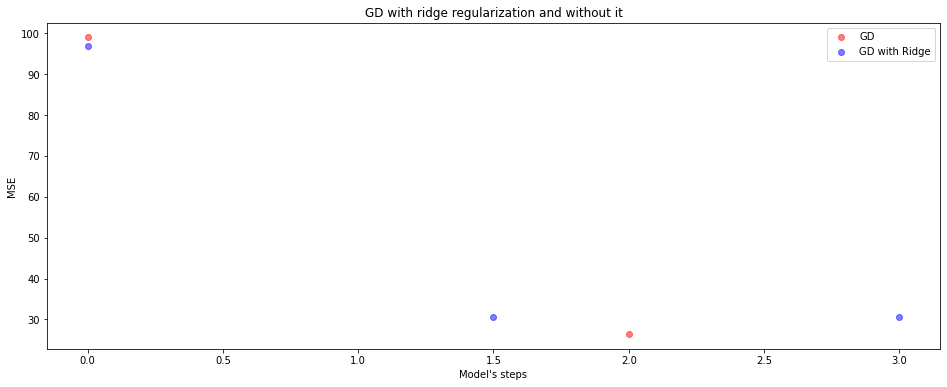

In [420]:
w_gd_ridge, y_gd_ridge, errors_gd_ridge, steps_number_gd_ridge = gradient_descent_regular(data, 
                                                                                        target,
                                                                                        start_speed_lr=0.5,
                                                                                        precision=1e-9,
                                                                                       lambda_=0.5)

w_gd, y_gd, errors_gd, steps_number_gd = gradient_descent(data, 
                                                          target,
                                                          start_speed_lr=0.5,
                                                          precision=1e-9)

plt.figure(figsize=(16, 6))
plt.scatter(np.linspace(start=0, stop=len(errors_gd), num=len(errors_gd)), errors_gd, c='red', alpha=0.5, label='GD')
plt.scatter(np.linspace(start=0, stop=len(errors_gd_ridge), num=len(errors_gd_ridge)), errors_gd_ridge, c='blue', alpha=0.5, label='GD with Ridge')
plt.xlabel("Model's steps")
plt.ylabel('MSE')
plt.title('GD with ridge regularization and without it')
plt.legend()
plt.show()



Градиентный спуск ведет себя также как и стахостический градиентный спуск: с регуляризацией ошибка возрастает и сходимость алгоритма значительно меньше 

### 3. Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

L1 регуляризация имеет вид

$$||w||_{1} = \sum^{d}_{j=1}|w_{j}|.$$

In [421]:
def calc_mse_lasso(y, w, X, lambda_):
    return sum((y - np.dot(X, w)) ** 2) / len(y) + lambda_ * np.sum(np.abs(w))

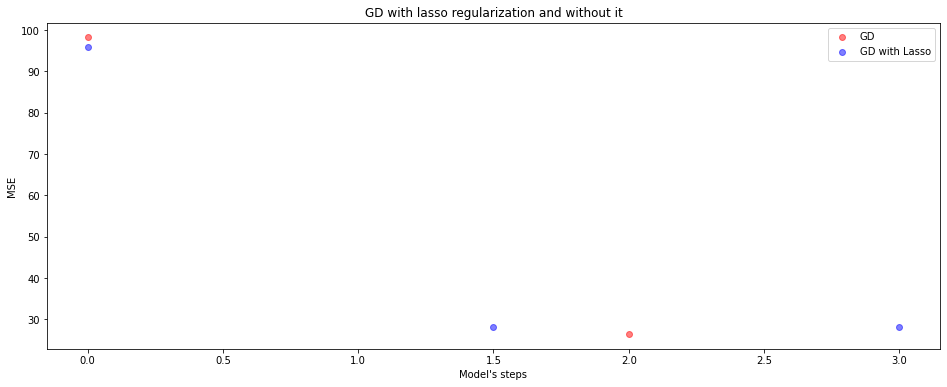

In [422]:
w_gd_lasso, y_gd_lasso, errors_gd_lasso, steps_number_gd_lasso = gradient_descent_regular(data, 
                                                                                        target,
                                                                                        start_speed_lr=0.5,
                                                                                        precision=1e-9,
                                                                                        lambda_=0.2, 
                                                                                        regularization_method=calc_mse_lasso)

w_gd, y_gd, errors_gd, steps_number_gd = gradient_descent(data, 
                                                          target,
                                                          start_speed_lr=0.5,
                                                          precision=1e-9)

plt.figure(figsize=(16, 6))
plt.scatter(np.linspace(start=0, stop=len(errors_gd), num=len(errors_gd)), errors_gd, c='red', alpha=0.5, label='GD')
plt.scatter(np.linspace(start=0, stop=len(errors_gd_lasso), num=len(errors_gd_lasso)), errors_gd_lasso, c='blue', alpha=0.5, label='GD with Lasso')
plt.xlabel("Model's steps")
plt.ylabel('MSE')
plt.title('GD with lasso regularization and without it')
plt.legend()
plt.show()

Из графика видно, что использование регуляризации увеличивает MSE

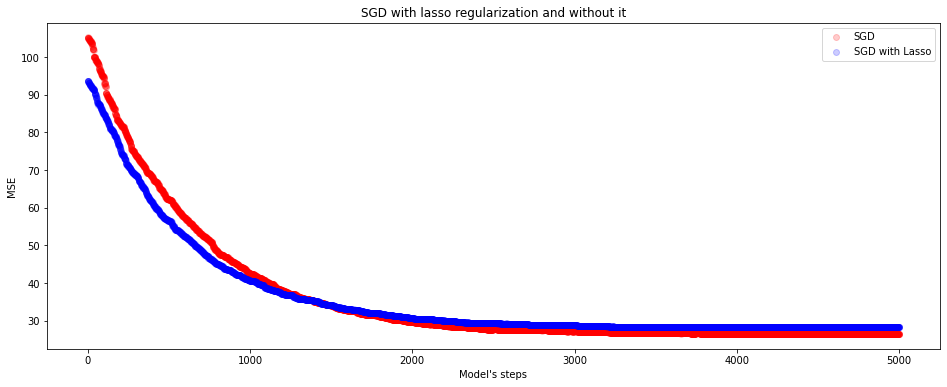

In [423]:
w_sgd_lasso, y_sgd_lasso, errors_sgd_lasso, steps_number_sgd_lasso = SGD_regular(data, 
                                                                               target, 
                                                                               eta=0.4, 
                                                                               max_steps_count=5000, 
                                                                               precision=1e-9, 
                                                                               lambda_=0.2,
                                                                               regularization_method=calc_mse_lasso)

w_sgd, y_sgd, errors_sgd, steps_number_sgd = SGD(data, 
                                                 target, 
                                                 eta=0.4, 
                                                 max_steps_count=5000, 
                                                 precision=1e-9)

plt.figure(figsize=(16, 6))
plt.scatter(np.linspace(start=0, stop=len(errors_sgd), num=len(errors_sgd)), errors_sgd, c='red', alpha=0.2, label='SGD')
plt.scatter(np.linspace(start=0, stop=len(errors_sgd_lasso), num=len(errors_sgd_lasso)), errors_sgd_lasso, c='blue', alpha=0.2, label='SGD with Lasso')
plt.xlabel("Model's steps")
plt.ylabel('MSE')
plt.title('SGD with lasso regularization and without it')
plt.legend()
plt.show()

Выводы аналогичные методу GD